# Modeling and Simulation in Python

Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state #extracts SIR from state object

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [5]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an example.|

In [6]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.46716293183605073


**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [29]:
# 1
def sickPeak(myResult):
    return myResult.I.max()

#2
def daySickPeak(myResult):
    return myResult.I.idxmax()
# 3 
def sickEnd(myResult):
    return myResult.I[len(myResult.I) - 1]

In [30]:
#1 value
sickPeak(results)
#Approx. 4.36% of students are sick at the peak of the outbreak.

0.043536202687592354

In [31]:
#2 value
daySickPeak(results)
# The outbreak peaks at day 30.

30

In [33]:
#3 value
sickEnd(results)
# At the end of the semester there are about 0.067% 
#of students who remain sick

0.0006741943156034474

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [34]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [35]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,98
beta,0.333333
gamma,0.25


And run the model without immunization.

In [36]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.468320811028781

Now with 10% immunization.

In [37]:
system2 = make_system(beta, gamma) #creates a new system
add_immunization(system2, 0.1) #includes imunization into the system
results2 = run_simulation(system2, update_func) #runs sim
calc_total_infected(results2) #calculate the total people infected

0.30650802853979753

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

Saving figure to file figs/chap12-fig01.pdf


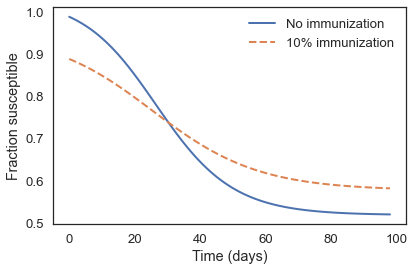

In [38]:
plot(results.S, '-', label='No immunization')
plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap12-fig01.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [39]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.468320811028781
0.1 0.30650802853979753
0.2 0.16136545700638427
0.30000000000000004 0.0728155898425179
0.4 0.03552021675299155
0.5 0.019688715782459176
0.6000000000000001 0.011622057998337987
0.7000000000000001 0.006838737800619332
0.8 0.003696496253713877
0.9 0.0014815326722661948
1.0 -0.00016121210941239666


This function does the same thing and stores the results in a `Sweep` object.

In [40]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [41]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

,values
0.00,0.468321
0.05,0.387288
0.10,0.306508
0.15,0.229234
0.20,0.161365
0.25,0.108791
0.30,0.072816
0.35,0.049938
0.40,0.035520
0.45,0.026121


And here's what the results look like.

Saving figure to file figs/chap12-fig02.pdf


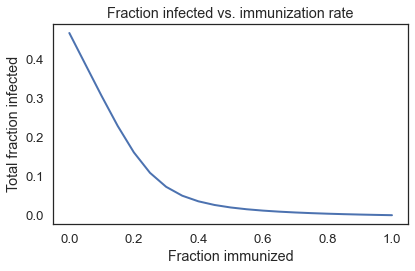

In [42]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('figs/chap12-fig02.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [43]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [44]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [45]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

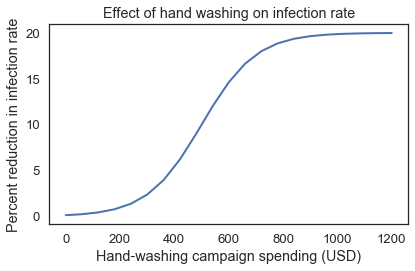

In [46]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

**Answer:** 
As 

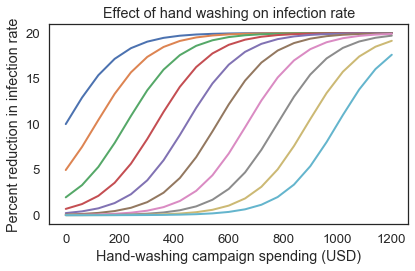

In [58]:
#create a function that iterates over different values of M
#between 0 and 1000
def changeM(spending):
    mValues = round(linspace(0, 1000, 10)) #range
    logList = [] #list to save numbers
    
    #iterate through list of M values and save results in List
    for i in mValues:
       logList.append(logistic(spending, M=i, K=0.2, B=0.01)) 
    return logList #return

#save list
percent_reduction_list = changeM(spending)

#plot each element in list
for i in percent_reduction_list:
    y = i *100 #scale
    plot(spending, y)
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

#As you can see as you can see, as M increases, the logistic
#function shifts to the right

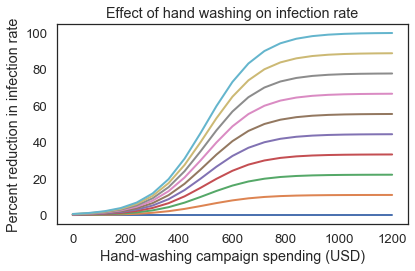

In [63]:
#create a function that iterates over different values of K
#between 0 and 1 (fraction for height)
def changeK(spending):
    kValues = linspace(0, 1, 10) #range
    logList = [] #list to save numbers
    
    #iterate through list of M values and save results in List
    for i in kValues:
       logList.append(logistic(spending, M=500, K=i, B=0.01)) 
    return logList #return

#save list
percent_reduction_list = changeK(spending)

#plot each element in list
for i in percent_reduction_list: 
    y = i * 100 #scale
    plot(spending, y)
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

#As you increase K the height of the function increases

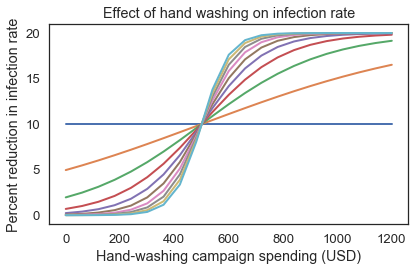

In [69]:
#create a function that iterates over different values of B
#between 0 and 0.02 (fraction for slope)
def changeB(spending):
    bValues = linspace(0, 0.02, 10) #range
    logList = [] #list to save numbers
    
    #iterate through list of M values and save results in List
    for i in bValues:
       logList.append(logistic(spending, M=500, K=0.2, B= i)) 
    return logList #return

#save list
percent_reduction_list = changeB(spending)

#plot each element in list
for i in percent_reduction_list: 
    y = i * 100 #scale
    plot(spending, y)
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

#As you increase B the slope of the function becomes steeper

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [70]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [71]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [72]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3328871432717143 0.4667702312363652
100.0 0.3321342526691939 0.46414165040064037
200.0 0.33017160845482885 0.4572170063132055
300.0 0.32538647186519215 0.4398872029120663
400.0 0.3154039052420003 0.40163064627138245
500.0 0.3 0.3370342594898199
600.0 0.28459609475799963 0.26731703056804546
700.0 0.2746135281348078 0.22184699045990752
800.0 0.26982839154517113 0.20079159841614402
900.0 0.2678657473308061 0.1923921833925878
1000.0 0.26711285672828566 0.18921320781833872
1100.0 0.26683150821044227 0.18803175228016467
1200.0 0.26672740341296003 0.1875955039953746


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [73]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [97]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

,values
0.000000,0.466770
63.157895,0.465418
126.315789,0.462905
189.473684,0.458291
252.631579,0.449980
315.789474,0.435540
378.947368,0.411960
442.105263,0.377183
505.263158,0.333171
568.421053,0.287633


And here's what it looks like.

Saving figure to file figs/chap12-fig03.pdf


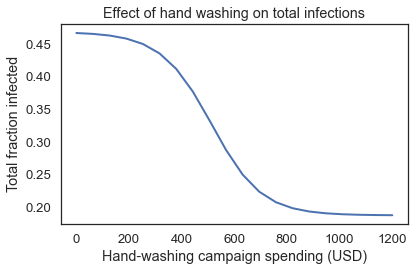

In [98]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('figs/chap12-fig03.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [99]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [100]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

0 0.9888888888888889 0.26672740341296003 0.1875955039953746
1 0.9777777777777779 0.26683150821044227 0.17458071882622528
2 0.9666666666666667 0.26711285672828566 0.16290983834857686
3 0.9555555555555556 0.2678657473308061 0.15350834947768177
4 0.9444444444444445 0.26982839154517113 0.1485650923152827
5 0.9333333333333333 0.2746135281348078 0.15294595061102179
6 0.9222222222222223 0.28459609475799963 0.1749644150235239
7 0.9111111111111112 0.3 0.21734316168444845
8 0.9 0.3154039052420003 0.2590710444883414
9 0.888888888888889 0.32538647186519215 0.27840288410342784
10 0.8777777777777778 0.33017160845482885 0.2779145346228302
11 0.8666666666666667 0.3321342526691939 0.2673574966927026
12 0.8555555555555556 0.3328871432717143 0.25279694563572175


The following function wraps that loop and stores the results in a `Sweep` object.

In [101]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [102]:
infected_sweep = sweep_doses(dose_array)

,values
0,0.187596
1,0.174581
2,0.162910
3,0.153508
4,0.148565
5,0.152946
6,0.174964
7,0.217343
8,0.259071
9,0.278403


And plot the results.

Saving figure to file figs/chap12-fig04.pdf


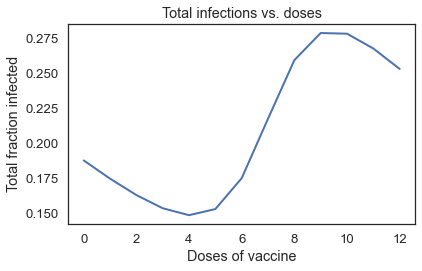

In [103]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap12-fig04.pdf')

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

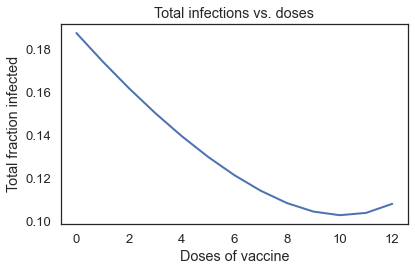

In [104]:
optimal_allocation1 = infected_sweep.min()

#change price per dose
price_per_dose = 50

#sweep again
infected_sweep = sweep_doses(dose_array)

#plot sweep
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

In [106]:
optimal_allocation1- infected_sweep.min()
#THE OPTIMAL ALLOCATION OF SPENDING DECREASES BY ABOUT 0.04578

0.04577699408837088

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

In [118]:
# Quarentine would affect the number of people that come in contact with an infected person
#lets say that anywhere between 20 - 75 percent of people who are infected 
#get quarentined
def quarentine(system, percentInfectedQ):
    #number of days between contact with someone in quarentine 
    #assuming that they stay in quarentine until they are not infectious
    dayQ = tr 
    #number of days between contact with someone infectious who is not in quarentine
    dayNotQ = 3 
    
    #Assuming that the time between contact
    #with an infectious person decreases by the 
    #percent of infected people who are not in quarentine
    #with a linear relationship
    tc = dayNotQ - dayQ*(1- percentInfectedQ)
    system.beta = 1/tc

In [123]:
percentInfectedQ = linspace(0.40, 0.75, 3)

def sweep_quarentine(percentInfectedQ):
    """Sweeps a range of values for quarentine.
    
    percentInfectedQ: decimal of people 
    infected who are put in quarentine
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in percentInfectedQ:
        system = make_system(beta, gamma)
        quarentine(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

infected_sweep = sweep_quarentine(percentInfectedQ)

,values
0.400,0.988897
0.575,0.950978
0.750,0.804506


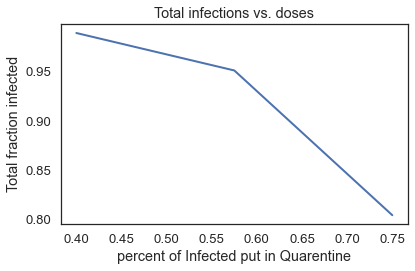

In [124]:
plot(infected_sweep)

decorate(xlabel='percent of Infected put in Quarentine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

In [125]:
#This is super rough though. I am not sure that the algorithm is correct
#I would have to look at the relationship between number of people
#infected and the number of people in quarentine and how that affects
#the number of days between infection.
#It may very well not be a linear relationship (which I assumed here it is).